# Fetching SDSS images for source classification

This notebook

- makes an SQL query to the SDSS DR12 database (using its [API](http://skyserver.sdss.org/dr12/en/help/docs/api.aspx)) to create a catalog, 
- downloads the FITS files,
- uses [Montage](http://montage.ipac.caltech.edu/) (and [montage wrapper](http://www.astropy.org/montage-wrapper/) to align each image to the image in the $r$-band, and
- uses [Sextractor](http://www.astromatic.net/software/sextractor) to find the pixel position of objects, and
- converts the fluxes in FITS files to [luptitudes](http://www.sdss.org/dr12/algorithms/magnitudes/#asinh).

This [Docker image](https://github.com/EdwardJKim/deeplearning4astro/tree/master/docker) has all packages necessary to run this notebook.

In [1]:
%matplotlib inline

import os
import shutil
import requests
import json
import bz2
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import montage_wrapper as mw
from astropy.io import fits
from astropy import wcs

[SpecObjAll](http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+SpecObjAll+U)

[PhotoObjAll](http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+PhotoObjAll+U)

Although there exists a precomputed join ([SpecPhotoAll](http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+SpecPhotoAll+U)) between the PhotoOjbAll and SpecObjAll tables, we do a join ourselves because SpecPhotoAll doesn't have some attributes we want, e.g. the clean photometry flag or the light profiles ("expRad" and "deVRad").

In [2]:
def sample_one_sq_deg(ra, dec, n=50000, dr="dr12", timeout=60):
    
    url = "http://skyserver.sdss.org/{}/en/tools/search/x_sql.aspx".format(dr)
    payload = {
        "format": "json",
        "cmd": """
            SELECT TOP {0} spec.specObjID,
                phot.objID,
                spec.ra,
                spec.dec,
                spec.class,
                spec.z,
                spec.zErr,
                phot.rerun,
                phot.run,
                phot.camcol,
                phot.field,
                phot.dered_u,
                phot.dered_g,
                phot.dered_r,
                phot.dered_i,
                phot.dered_z
            FROM SpecObjAll AS spec
            JOIN PhotoObjAll AS phot
            ON spec.specObjID = phot.specObjID
            WHERE
                phot.clean = 1
                AND spec.zWarning = 0
                AND spec.ra >= {1}
                AND spec.ra < {2}
                AND spec.dec >= {3}
                AND spec.dec < {4}
                AND phot.dered_r > 0 and phot.dered_r < 40
                AND phot.expRad_r < 30
                AND phot.deVRad_r < 30
                AND spec.zErr < 0.1
                AND spec.z < 2
            ORDER BY NEWID()
        """.format(n, ra, ra + 1, dec, dec + 1).strip()
    }
    
    try:
        resp = requests.post(url, params=payload, timeout=timeout)
    except requests.exceptions.RequestException as e:
        print(e)
        return None

    data = resp.json()[0]['Rows']
    
    df = pd.DataFrame(data)

    return df

In [3]:
df = pd.DataFrame()

'''
for ra in range(0, 2):
    for dec in range(-1, 1):
        
        s = sample_one_sq_deg(ra, dec, n=1)

        df = df.append(s)
        
        if not os.path.exists("catalog"):
            os.makedirs("catalog")
'''

df = sample_one_sq_deg(0, 0, n=200, dr="dr10")
df.to_csv("objects.csv", index=False)

print(df)

     camcol   class       dec   dered_g   dered_i   dered_r   dered_u  \
0         5  GALAXY  0.765828  21.69221  18.95345  19.97915  25.43051   
1         4    STAR  0.350178  21.34135  18.79153  20.03214  22.93500   
2         4  GALAXY  0.295010  18.51891  17.80208  18.09819  19.86126   
3         6  GALAXY  0.849424  22.52832  19.81044  20.98203  23.29944   
4         5  GALAXY  0.651681  20.98772  18.59610  19.23095  22.96073   
5         6  GALAXY  0.843844  18.23614  17.55142  17.81549  19.15593   
6         5  GALAXY  0.458866  22.05699  19.54153  20.48987  22.89008   
7         6    STAR  0.942317  18.20797  16.16326  16.86496  20.87287   
8         6  GALAXY  0.882939  22.20182  19.74754  20.81809  25.26339   
9         5  GALAXY  0.619943  19.44228  17.79671  18.26362  21.85949   
10        4    STAR  0.255389  15.68500  15.06988  15.27283  16.82753   
11        5    STAR  0.567541  20.79985  17.99937  19.44734  23.72684   
12        6    STAR  0.982151  17.43394  15.13985  

Images and derived catalog data are described on the imaging data page. You can use a SkyServer search or the file window_flist.fits file to identify which RERUN-RUN-CAMCOL-FIELD overlaps your region of interest. Then download the matching calibObj files (catalog data) or frame files (calibrated imaging data), e.g., for RERUN 301, RUN 2505, CAMCOL 3, FIELD 38, the r-band image is:

```shell
$ wget --spider http://data.sdss3.org/sas/dr12/boss/photoObj/frames/301/2505/3/frame-r-002505-3-0038.fits.bz2
```

In [4]:
def fetch_fits(df):

    bands = [c for c in 'ugriz']
    
    run = df[["rerun", "run", "camcol", "field"]].drop_duplicates()
    
    if not os.path.exists("images/raw"):
        os.makedirs("images/raw")

    for i, r in run.iterrows():
        
        for band in bands:
            url = "http://data.sdss3.org/sas/dr12/boss/photoObj/frames/{0}/{1}/{2}/".format(
                r.rerun, r.run, r.camcol, r.field, band)
            filename = "frame-{4}-{1:06d}-{2}-{3:04d}.fits.bz2".format(
                r.rerun, r.run, r.camcol, r.field, band)
            filepath = os.path.join("images/raw", filename)
            
            if os.path.exists(filepath.replace(".bz2", "")):
                print("Skipping {}".format(filename))
            else:
                print("Downloading and extracting {}".format(filename))
                
                resp = requests.get(url + filename, stream=True)
            
                with open(filepath.replace(".bz2", ""), "wb") as f:
                    img = bz2.decompress(resp.content)
                    f.write(img)

In [5]:
fetch_fits(df)

Skipping frame-u-002728-5-0416.fits.bz2
Skipping frame-g-002728-5-0416.fits.bz2
Skipping frame-r-002728-5-0416.fits.bz2
Skipping frame-i-002728-5-0416.fits.bz2
Skipping frame-z-002728-5-0416.fits.bz2
Skipping frame-u-004874-4-0422.fits.bz2
Skipping frame-g-004874-4-0422.fits.bz2
Skipping frame-r-004874-4-0422.fits.bz2
Skipping frame-i-004874-4-0422.fits.bz2
Skipping frame-z-004874-4-0422.fits.bz2
Skipping frame-u-004874-4-0424.fits.bz2
Skipping frame-g-004874-4-0424.fits.bz2
Skipping frame-r-004874-4-0424.fits.bz2
Skipping frame-i-004874-4-0424.fits.bz2
Skipping frame-z-004874-4-0424.fits.bz2
Skipping frame-u-004145-6-0111.fits.bz2
Skipping frame-g-004145-6-0111.fits.bz2
Skipping frame-r-004145-6-0111.fits.bz2
Skipping frame-i-004145-6-0111.fits.bz2
Skipping frame-z-004145-6-0111.fits.bz2
Skipping frame-u-002728-5-0414.fits.bz2
Skipping frame-g-002728-5-0414.fits.bz2
Skipping frame-r-002728-5-0414.fits.bz2
Skipping frame-i-002728-5-0414.fits.bz2
Skipping frame-z-002728-5-0414.fits.bz2


In [6]:
ref_images = []

run = df[["rerun", "run", "camcol", "field"]].drop_duplicates()
for row in run.iterrows():
    r = row[1]
    filename = "frame-r-{1:06d}-{2}-{3:04d}.fits".format(r.rerun, r.run, r.camcol, r.field)
    ref_images.append(filename)

print(ref_images)

['frame-r-002728-5-0416.fits', 'frame-r-004874-4-0422.fits', 'frame-r-004874-4-0424.fits', 'frame-r-004145-6-0111.fits', 'frame-r-002728-5-0414.fits', 'frame-r-004145-6-0115.fits', 'frame-r-004145-5-0113.fits', 'frame-r-004145-6-0110.fits', 'frame-r-004145-5-0115.fits', 'frame-r-004207-4-0377.fits', 'frame-r-004145-5-0116.fits', 'frame-r-004145-6-0116.fits', 'frame-r-004874-4-0423.fits', 'frame-r-004263-4-0117.fits', 'frame-r-004145-5-0112.fits', 'frame-r-004263-4-0120.fits', 'frame-r-004145-5-0110.fits', 'frame-r-004874-4-0421.fits', 'frame-r-004263-4-0122.fits', 'frame-r-002728-5-0413.fits', 'frame-r-004145-6-0113.fits', 'frame-r-002728-5-0417.fits', 'frame-r-004207-4-0376.fits', 'frame-r-002728-5-0415.fits', 'frame-r-004145-6-0114.fits', 'frame-r-004263-4-0119.fits', 'frame-r-002728-5-0418.fits', 'frame-r-004145-6-0112.fits', 'frame-r-004207-4-0378.fits', 'frame-r-004145-5-0114.fits', 'frame-r-004263-4-0116.fits', 'frame-r-004145-5-0111.fits', 'frame-r-004145-5-0117.fits', 'frame-r-

[re-projection](http://montage.ipac.caltech.edu/docs/algorithms.html)

Montage sometimes throws the following error:

```
MontageError: mProject: File (/notebooks/shared/images/raw/frame-z-007712-3-0338.fits) is not a FITS image
```

When this happens, deleting the offending file and reruning `fetch_fits()` fixes the error.

In [7]:
if not os.path.exists("images/header"):
    os.makedirs("images/header")

if not os.path.exists("images/registered"):
    os.makedirs("images/registered")

for image in ref_images:
    
    print("Processing {}...".format(image))

    for b in "ugriz":
        frame_path = os.path.join("images/raw", image.replace("frame-r-", "frame-{}-").format(b))
        registered_path = os.path.join("images/registered", image.replace("frame-r-", "registered-{}-").format(b))
        
        if not os.path.exists(registered_path):
            header = os.path.join("images/header", image.replace("frame", "header").replace(".fits", ".hdr"))
            mw.commands.mGetHdr(os.path.join("images/raw", image), header)
            mw.reproject(frame_path, registered_path, header=header, exact_size=True, common=True, silent_cleanup=True)

Processing frame-r-002728-5-0416.fits...
Processing frame-r-004874-4-0422.fits...
Processing frame-r-004874-4-0424.fits...
Processing frame-r-004145-6-0111.fits...
Processing frame-r-002728-5-0414.fits...
Processing frame-r-004145-6-0115.fits...
Processing frame-r-004145-5-0113.fits...
Processing frame-r-004145-6-0110.fits...
Processing frame-r-004145-5-0115.fits...
Processing frame-r-004207-4-0377.fits...
Processing frame-r-004145-5-0116.fits...
Processing frame-r-004145-6-0116.fits...
Processing frame-r-004874-4-0423.fits...
Processing frame-r-004263-4-0117.fits...
Processing frame-r-004145-5-0112.fits...
Processing frame-r-004263-4-0120.fits...
Processing frame-r-004145-5-0110.fits...
Processing frame-r-004874-4-0421.fits...
Processing frame-r-004263-4-0122.fits...
Processing frame-r-002728-5-0413.fits...
Processing frame-r-004145-6-0113.fits...
Processing frame-r-002728-5-0417.fits...
Processing frame-r-004207-4-0376.fits...
Processing frame-r-002728-5-0415.fits...
Processing frame

In [8]:
def convert_catalog_to_pixels(df):

    pixels = pd.DataFrame()

    for i, r in df.iterrows():

        fits_file = "registered-r-{1:06d}-{2}-{3:04d}.fits".format(
            r.rerun, r.run, r.camcol, r.field)
        fits_path = os.path.join("images/registered", fits_file)
            
        hdulist = fits.open(fits_path)

        w = wcs.WCS(hdulist[0].header, relax=False)
        
        px, py = w.all_world2pix(r.ra, r.dec, 1)

        pixels.loc[i, "file"] = fits_file
        pixels.loc[i, "px"] = px
        pixels.loc[i, "py"] = py
        pixels.loc[i, "class"] = r["class"]
        
        pixel_list = fits_file.replace(".fits", ".list")
        pixel_path = os.path.join("catalog", pixel_list)
        
    for fits_file in pixels.file.unique():
        pixel_list = fits_file.replace(".fits", ".list")
        pixel_path = os.path.join("catalog", pixel_list)
        p = pixels[pixels.file == fits_file]
        p[["px", "py", "class"]].to_csv(pixel_path, sep= " ", header=False)

In [9]:
convert_catalog_to_pixels(df)

RADECSYS is non-standard, use RADESYSa. [astropy.wcs.wcs]
RADECSYS is non-standard, use RADESYSa.


In [10]:
%%writefile default.conv
CONV NORM
# 3x3 ``all-ground'' convolution mask with FWHM = 2 pixels.
1 2 1
2 4 2
1 2 1

Overwriting default.conv


In [11]:
%%writefile default.param
XMIN_IMAGE               Minimum x-coordinate among detected pixels                [pixel]
YMIN_IMAGE               Minimum y-coordinate among detected pixels                [pixel]
XMAX_IMAGE               Maximum x-coordinate among detected pixels                [pixel]
YMAX_IMAGE               Maximum y-coordinate among detected pixels                [pixel]
VECTOR_ASSOC(1)          #ASSOCiated parameter vector

Overwriting default.param


In [12]:
%%writefile default.sex
#-------------------------------- Catalog ------------------------------------
 
CATALOG_NAME     test.cat       # name of the output catalog
CATALOG_TYPE     ASCII_HEAD     # NONE,ASCII,ASCII_HEAD, ASCII_SKYCAT,
                                # ASCII_VOTABLE, FITS_1.0 or FITS_LDAC
PARAMETERS_NAME  default.param  # name of the file containing catalog contents
 
#------------------------------- Extraction ----------------------------------
 
DETECT_TYPE      CCD            # CCD (linear) or PHOTO (with gamma correction)
DETECT_MINAREA   3              # min. # of pixels above threshold
DETECT_THRESH    1.5            # <sigmas> or <threshold>,<ZP> in mag.arcsec-2
ANALYSIS_THRESH  1.5            # <sigmas> or <threshold>,<ZP> in mag.arcsec-2
 
FILTER           Y              # apply filter for detection (Y or N)?
FILTER_NAME      default.conv   # name of the file containing the filter
 
DEBLEND_NTHRESH  32             # Number of deblending sub-thresholds
DEBLEND_MINCONT  0.005          # Minimum contrast parameter for deblending
 
CLEAN            Y              # Clean spurious detections? (Y or N)?
CLEAN_PARAM      1.0            # Cleaning efficiency
 
MASK_TYPE        CORRECT        # type of detection MASKing: can be one of
                                # NONE, BLANK or CORRECT

#------------------------------ Photometry -----------------------------------
 
PHOT_APERTURES   5              # MAG_APER aperture diameter(s) in pixels
PHOT_AUTOPARAMS  2.5, 3.5       # MAG_AUTO parameters: <Kron_fact>,<min_radius>
PHOT_PETROPARAMS 2.0, 3.5       # MAG_PETRO parameters: <Petrosian_fact>,
                                # <min_radius>

SATUR_LEVEL      50000.0        # level (in ADUs) at which arises saturation
SATUR_KEY        SATURATE       # keyword for saturation level (in ADUs)
 
MAG_ZEROPOINT    0.0            # magnitude zero-point
MAG_GAMMA        4.0            # gamma of emulsion (for photographic scans)
GAIN             0.0            # detector gain in e-/ADU
GAIN_KEY         GAIN           # keyword for detector gain in e-/ADU
PIXEL_SCALE      1.0            # size of pixel in arcsec (0=use FITS WCS info)
 
#------------------------- Star/Galaxy Separation ----------------------------
 
SEEING_FWHM      1.2            # stellar FWHM in arcsec
STARNNW_NAME     default.nnw    # Neural-Network_Weight table filename
 
#------------------------------ Background -----------------------------------
 
BACK_SIZE        64             # Background mesh: <size> or <width>,<height>
BACK_FILTERSIZE  3              # Background filter: <size> or <width>,<height>
 
BACKPHOTO_TYPE   GLOBAL         # can be GLOBAL or LOCAL
 
#------------------------------ Check Image ----------------------------------
 
CHECKIMAGE_TYPE  SEGMENTATION   # can be NONE, BACKGROUND, BACKGROUND_RMS,
                                # MINIBACKGROUND, MINIBACK_RMS, -BACKGROUND,
                                # FILTERED, OBJECTS, -OBJECTS, SEGMENTATION,
                                # or APERTURES
CHECKIMAGE_NAME  check.fits     # Filename for the check-image
 
#--------------------- Memory (change with caution!) -------------------------
 
MEMORY_OBJSTACK  3000           # number of objects in stack
MEMORY_PIXSTACK  300000         # number of pixels in stack
MEMORY_BUFSIZE   1024           # number of lines in buffer
 
#----------------------------- Miscellaneous ---------------------------------
 
VERBOSE_TYPE     NORMAL         # can be QUIET, NORMAL or FULL
HEADER_SUFFIX    .head          # Filename extension for additional headers
WRITE_XML        N              # Write XML file (Y/N)?
XML_NAME         sex.xml        # Filename for XML output

#----------------------------- ASSOC parameters ---------------------------------

ASSOC_NAME       sky.list       # name of the ASCII file to ASSOCiate, the expected pixel 
                                # coordinates list given as [id, xpos, ypos]
ASSOC_DATA       1              # columns of the data to replicate (0=all), replicate id
                                # of the object in the SExtractor output file
ASSOC_PARAMS     2,3            # columns of xpos,ypos[,mag] in the expected pixel
                                # coordinates list
ASSOC_RADIUS     2.0            # cross-matching radius (pixels)
ASSOC_TYPE       NEAREST        # ASSOCiation method: FIRST, NEAREST, MEAN,
                                # MAG_MEAN, SUM, MAG_SUM, MIN or MAX
ASSOCSELEC_TYPE  MATCHED        # ASSOC selection type: ALL, MATCHED or -MATCHED

Overwriting default.sex


In [13]:
cat = pd.DataFrame()

registered_all = [f.replace("frame-", "registered-") for f in ref_images]

for f in registered_all:
    
    fpath = os.path.join("images/registered", f)
    
    list_file = f.replace(".fits", ".list")
    list_path = os.path.join("catalog", list_file)

    with open("default.sex", "r") as default, open("default.sex.temp", "w") as temp:
        for line in default:
            line = re.sub(
                r"^ASSOC_NAME\s+sky.list",
                "ASSOC_NAME       {}".format(list_file),
                line
            )
            temp.write(line)

    shutil.copy(list_path, os.getcwd())

    !sex -c default.sex.temp -VERBOSE_TYPE quiet $fpath
    
    os.remove("default.sex.temp")

    try:
        assoc = pd.read_csv(
            "test.cat",
            comment="#",
            header=None,
            delim_whitespace=True,
            names=["xmin", "ymin", "xmax", "ymax", "match"]
        )
        assoc["file"] = f
        cat = cat.append(assoc)
    except:
        pass
    
    os.remove(os.path.join(os.getcwd(), list_file))
        
cat["class"] = df.iloc[cat["match"]]["class"].values
cat["objID"] = df.iloc[cat["match"]]["objID"].values
cat = cat.reset_index(drop=True)

print(cat)

     xmin  ymin  xmax  ymax  match                             file   class  \
0    1734   377  1740   384    199  registered-r-002728-5-0416.fits    STAR   
1    1146   471  1189   523     33  registered-r-002728-5-0416.fits  GALAXY   
2    1575   388  1581   393    151  registered-r-002728-5-0416.fits  GALAXY   
3     973   576   995   599    150  registered-r-002728-5-0416.fits  GALAXY   
4     637  1394   646  1405    159  registered-r-002728-5-0416.fits    STAR   
5    1296  1091  1307  1099      0  registered-r-002728-5-0416.fits  GALAXY   
6    1202   165  1207   170    104  registered-r-004874-4-0422.fits     QSO   
7     531   681   557   699    101  registered-r-004874-4-0422.fits  GALAXY   
8    1343  1350  1348  1356      1  registered-r-004874-4-0422.fits    STAR   
9     564  1124   570  1130     55  registered-r-004874-4-0422.fits     QSO   
10    832   143   853   183      2  registered-r-004874-4-0424.fits  GALAXY   
11   1040   399  1047   404     79  registered-r-004

In [14]:
def nanomaggie_to_luptitude(array, band):
    '''
    Converts nanomaggies (flux) to luptitudes (magnitude).

    http://www.sdss.org/dr12/algorithms/magnitudes/#asinh
    http://arxiv.org/abs/astro-ph/9903081
    '''
    b = {
        'u': 1.4e-10,
        'g': 0.9e-10,
        'r': 1.2e-10,
        'i': 1.8e-10,
        'z': 7.4e-10
    }
    nanomaggie = array * 1.0e-9 # fluxes are in nanomaggies

    luptitude = -2.5 / np.log(10) * (np.arcsinh((nanomaggie / (2 * b[band]))) + np.log(b[band]))
    
    return luptitude

In [28]:
def save_rgb_cutout(df, size=32):

    if not os.path.exists("images/cutout"):
        os.makedirs("images/cutout")

    bad_rows = []

    for i, row in df.iterrows():
     
        array = np.zeros((size, size, 3), dtype=np.uint8)

        for j, b in enumerate("gri"):

            fpath = os.path.join("images/registered", row.file)
            image_data = fits.getdata(fpath.replace("-r-", "-{}-".format(b)))
    
            y0, x0, y1, x1 = row[0:4].values

            right = max(0.5 * (size - (x1 - x0)), 1)
            left = max(0.5 * (size - (x1 - x0)), 0)
            up = max(0.5 * (size - (y1 - y0)), 0)
            down = max(0.5 * (size - (y1 - y0)), 1)
    
            cut_out = image_data[x0 - right: x1 + left, y0 - down: y1 + up]
        
            if (np.isnan(cut_out).sum() == 0
                and cut_out.shape[0] == size
                and cut_out.shape[1] == size):
            
                cut_out = nanomaggie_to_luptitude(cut_out, b)

                max_val = cut_out.max()
                min_val = cut_out.min()
    
                cut_out = (max_val - cut_out) / (max_val - min_val) * 255
        
                array[:, :, j] = cut_out
                
                save_path = os.path.join("images/cutout", "{}.{}.npy".format(row["class"], row["objID"]))
                np.save(save_path, array)

            else:
                bad_rows.append(i)
        
    # drop duplicates
    bad_rows = list(set(bad_rows))
    
    result = df.drop(df.index[bad_rows])
    
    return result

In [29]:
result = save_rgb_cutout(cat)

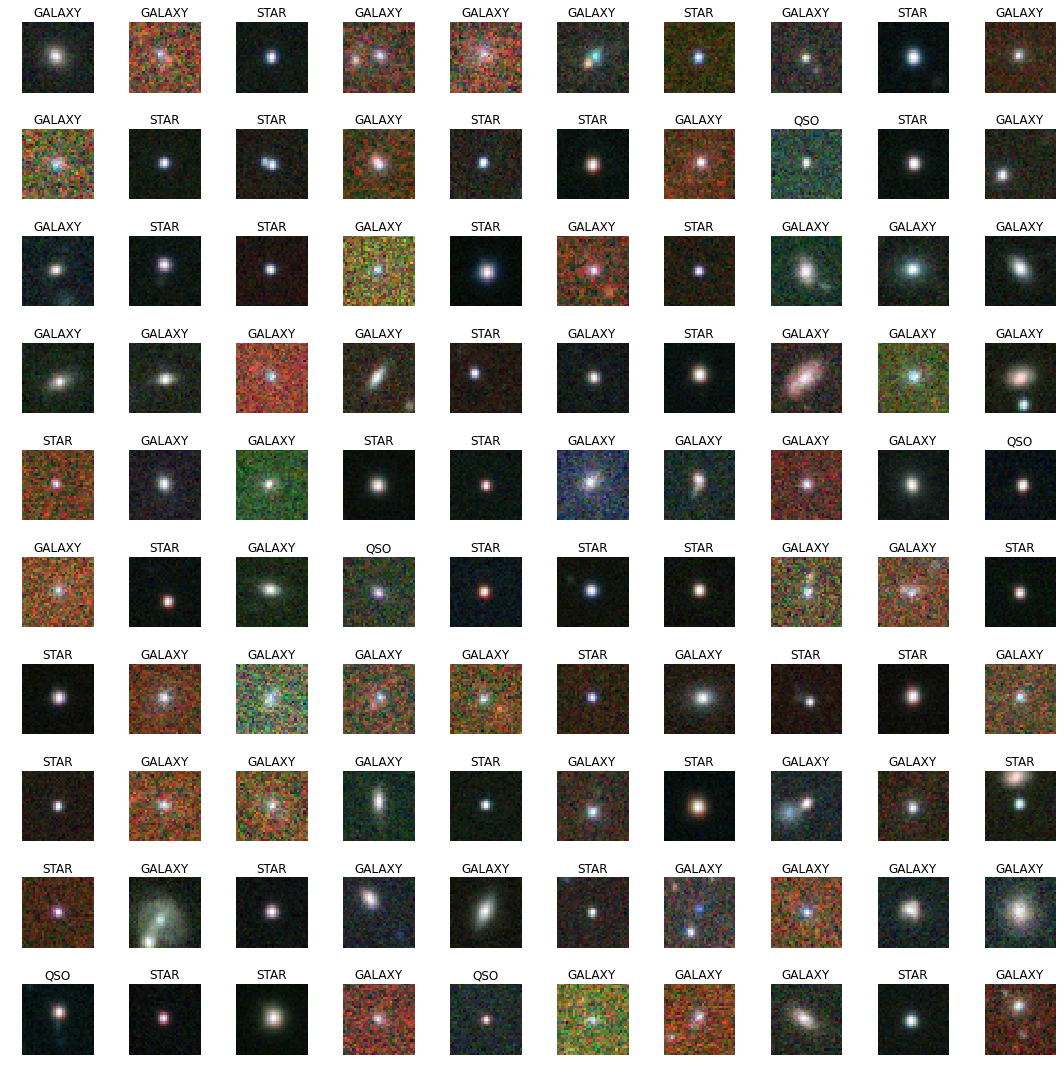

In [30]:
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
fig.tight_layout()

all_cutout = os.listdir("images/cutout")

size = 32

for i, f in enumerate(all_cutout[:100]):
    
    fpath = os.path.join("images/cutout", f)
    cutout = np.load(fpath)
    row, col = i // 10, i % 10
    ax[row, col].imshow(cutout, interpolation="nearest")
    ax[row, col].axis("off")
    ax[row, col].set_title(f.split(".")[0])

In [38]:
def save_cutout(df, size=32):

    if not os.path.exists("result"):
        os.makedirs("result")

    bad_rows = []

    for i, row in df.iterrows():
     
        array = np.zeros((5, size, size), dtype=np.uint8)

        for j, b in enumerate("ugriz"):

            fpath = os.path.join("images/registered", row.file)
            image_data = fits.getdata(fpath.replace("-r-", "-{}-".format(b)))
    
            y0, x0, y1, x1 = row[0:4].values

            right = max(0.5 * (size - (x1 - x0)), 1)
            left = max(0.5 * (size - (x1 - x0)), 0)
            up = max(0.5 * (size - (y1 - y0)), 0)
            down = max(0.5 * (size - (y1 - y0)), 1)
    
            cut_out = image_data[x0 - right: x1 + left, y0 - down: y1 + up]
        
            if (np.isnan(cut_out).sum() == 0
                and cut_out.shape[0] == size
                and cut_out.shape[1] == size):
            
                cut_out = nanomaggie_to_luptitude(cut_out, b)
        
                array[j, :, :] = cut_out
                
                save_path = os.path.join("result", "{}.{}.npy".format(row["class"], row["objID"]))
                np.save(save_path, array)
                
            else:
                bad_rows.append(i)
        
    # drop duplicates
    bad_rows = list(set(bad_rows))
    
    result = df.drop(df.index[bad_rows])

    print("{} files saved.".format(len(result)))

In [39]:
save_cutout(cat)

162 files saved.
